In [3]:
import os
import torch
import tqdm
import pandas as pd
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [5]:
class LoadDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.img_ids = self.df["ID"]
        self.reviews = self.df["Review"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        review = self.reviews[index]

        try:
            img = Image.open(os.path.join(self.root_dir, str(img_id) + ".jpg")).convert("RGB")
        except FileNotFoundError:
            img = Image.open(os.path.join(self.root_dir, str(img_id) + ".png")).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        if review == "dank":
            label = torch.tensor(1.0, dtype=torch.float)
        else:
            label = torch.tensor(0.0, dtype=torch.float)

        return img, label

In [6]:
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor()])

In [7]:
device

device(type='cuda')

In [8]:
data = LoadDataset("memes/", "meme_reviews.csv", transform)
total_size = len(data)
train_size = int(0.7 * total_size)
train_data, val_data = random_split(data, [train_size, total_size - train_size])

In [9]:
len(train_data), len(val_data)

(2248, 964)

In [10]:
train_batches = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_batches = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [11]:
len(train_batches), len(val_batches)

(36, 16)

In [12]:
img, review = train_data[42]

(tensor(0.), <matplotlib.image.AxesImage at 0x7f24ba9d7c88>)

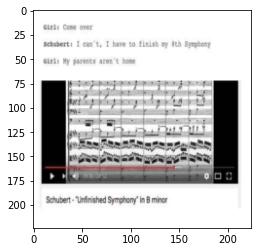

In [13]:
review, plt.imshow(img.permute(1, 2, 0))

In [14]:
net = models.resnet18(pretrained=True)

In [15]:
for param in net.parameters():
    param.requires_grad = False

In [16]:
net.fc = nn.Sequential(nn.Linear(512, 100), 
                                  nn.ReLU(), 
                                  nn.Linear(100, 1))

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
input = torch.randn(1, 3, 224, 224).to(device)
output = net(input)
output.shape

torch.Size([1, 1])

In [18]:
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

In [19]:
def get_accuracy(preds, y):
    preds = torch.round(torch.sigmoid(preds))
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)

    return acc

In [20]:
def loop(net, batches, train):
    batch_losses = []
    batch_accs = []
    
    if train:
        print("Train Loop:")
        print("")
        net.train()

        for img, rvw in tqdm.tqdm(batches, total=len(batches)):
            imgs = img.to(device)
            rvws = rvw.to(device)

            preds = net(imgs)
            preds = preds.squeeze(1)

            loss = loss_fn(preds, rvws)
            acc = get_accuracy(preds, rvws)

            opt.zero_grad()
            loss.backward()
            opt.step()

            batch_losses.append(loss.item())
            batch_accs.append(acc)

    else:
        print("Validation Loop:")
        print("")
        net.eval()

        with torch.no_grad():
            for img, rvw in tqdm.tqdm(batches, total=len(batches)):
                imgs = img.to(device)
                rvws = rvw.to(device)

                preds = net(imgs)
                preds = preds.squeeze(1)

                loss = loss_fn(preds, rvws)
                acc = get_accuracy(preds, rvws)

                batch_losses.append(loss.item())
                batch_accs.append(acc)

    print("")
    print("")
    
    return sum(batch_losses) / len(batch_losses), sum(batch_accs) / len(batch_accs)

In [34]:
def review_meme(net, meme, transform, device):
    img = Image.open(meme).convert("RGB")
    img = transform(img).to(device)
    net.eval()
    
    with torch.no_grad():
        pred = net(img.unsqueeze(0))
    
    rvw = torch.sigmoid(pred.squeeze(1))
    if torch.round(rvw) == 1:
        print("This is a Dank Meme!!")
    else:
        print("This is NOT a Dank Meme!!")

    print(f"Score: {rvw.item() * 10:.2f}/10")

In [22]:
def save_checkpoint(net, opt, filename):
    check_point = {"net_dict": net.state_dict(), "opt_dict": opt.state_dict()}
    torch.save(check_point, filename)
    print("Checkpoint Saved!")

def load_checkpoint(net, opt, filename):
    check_point = torch.load(filename)
    net.load_state_dict(check_point["net_dict"])
    opt.load_state_dict(check_point["opt_dict"])
    print("Checkpoint Loaded!")

In [23]:
for epoch in range(epochs):
    train_loss, train_acc = loop(net, train_batches, True)
    val_loss, val_acc = loop(net, val_batches, False)
    
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
    print("")

  0%|          | 0/36 [00:00<?, ?it/s]

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 0 | train_loss: 0.6315 | train_acc: 0.6654 | val_loss: 0.6107 | val_acc: 0.6709

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 1 | train_loss: 0.5935 | train_acc: 0.6992 | val_loss: 0.5563 | val_acc: 0.7510

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 2 | train_loss: 0.5676 | train_acc: 0.7218 | val_loss: 0.5825 | val_acc: 0.7168

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 3 | train_loss: 0.5628 | train_acc: 0.7274 | val_loss: 0.5445 | val_acc: 0.7676

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 4 | train_loss: 0.5560 | train_acc: 0.7374 | val_loss: 0.5747 | val_acc: 0.7412

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 5 | train_loss: 0.5409 | train_acc: 0.7422 | val_loss: 0.5818 | val_acc: 0.7324

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 6 | train_loss: 0.5380 | train_acc: 0.7391 | val_loss: 0.5444 | val_acc: 0.7617

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 7 | train_loss: 0.5308 | train_acc: 0.7457 | val_loss: 0.5772 | val_acc: 0.7393

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 8 | train_loss: 0.5396 | train_acc: 0.7487 | val_loss: 0.5571 | val_acc: 0.7568

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 9 | train_loss: 0.5196 | train_acc: 0.7565 | val_loss: 0.5761 | val_acc: 0.7305

Train Loop:



  0%|          | 0/16 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/36 [00:00<?, ?it/s]



epoch: 10 | train_loss: 0.5218 | train_acc: 0.7491 | val_loss: 0.5588 | val_acc: 0.7617

Train Loop:



  8%|▊         | 3/36 [00:04<00:58,  1.78s/it]

KeyboardInterrupt: ignored

In [35]:
review_meme(net, "test_images/cow.jpg", transform, device)

This is a Dank Meme!!
Score: 7.26/10


In [36]:
review_meme(net, "test_images/quack.jpg", transform, device)

This is NOT a Dank Meme!!
Score: 3.05/10


In [38]:
review_meme(net, "test_images/trash.jpg", transform, device)

This is NOT a Dank Meme!!
Score: 2.33/10


In [39]:
review_meme(net, "test_images/yoda.jpg", transform, device)

This is NOT a Dank Meme!!
Score: 4.94/10


In [40]:
review_meme(net, "test_images/fan.jpg", transform, device)

This is a Dank Meme!!
Score: 6.42/10


In [41]:
review_meme(net, "test_images/bear.jpg", transform, device)

This is a Dank Meme!!
Score: 7.72/10
